In [ ]:
print('test')
print('test')

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
from scipy.fft import rfft, rfftfreq, irfft
from time import sleep
import sounddevice as sd
from scipy.io.wavfile import write
import time
import os
import time
from scipy import integrate
from scipy.interpolate import interp1d
import time

class MyDAQ:
    def __init__(self):
        self.__samplerate = None
        self.__name = None

    @property
    def samplerate(self) -> int:
        return self.__samplerate

    @samplerate.setter
    def samplerate(self, newSamplerate: int) -> None:
        assert isinstance(newSamplerate, int), "Samplerate should be an integer."
        assert newSamplerate > 0, "Samplerate should be positive."
        self.__samplerate = newSamplerate

    @property
    def name(self) -> str:
        return self.__name

    @name.setter
    def name(self, newName: str) -> None:
        assert isinstance(newName, str), "Name should be a string."
        self.__name = newName

    def _addOutputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add output channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ao_channels.add_ao_voltage_chan(channel)
            else:
                task.ao_channels.add_ao_voltage_chan(f"{self.name}/{channel}")

    def _addInputChannels(self, task: dx.task.Task, channels: str | list[str]) -> None:
        """
        Add input channels to the DAQ
        """
        assert not (self.name is None), "Name should be set first."

        # Make sure channels can be iterated over
        if isinstance(channels, str):
            channels = [channels]

        # Iterate over all channels and add to task
        for channel in channels:
            if self.name in channel:
                task.ai_channels.add_ai_voltage_chan(channel)
            else:
                task.ai_channels.add_ai_voltage_chan(f"{self.name}/{channel}")

    def _configureChannelTimings(self, task: dx.task.Task, samples: int) -> None:
        """
        Set the correct timings for task based on number of samples
        """
        assert not (self.samplerate is None), "Samplerate should be set first."

        task.timing.cfg_samp_clk_timing(
            self.samplerate,
            sample_mode=dx.constants.AcquisitionType.FINITE,
            samps_per_chan=samples,
        )

    @staticmethod
    def convertDurationToSamples(samplerate: int, duration: float) -> int:
        samples = duration * samplerate

        # Round down to nearest integer
        return int(samples)

    @staticmethod
    def convertSamplesToDuration(samplerate: int, samples: int) -> float:
        duration = samples / samplerate

        return duration

    def read(self, duration: float, *channels: str, timeout: float = 300) -> np.ndarray:
        """
        Read from user-specified channels for `duration` seconds
        """

        # Convert duration to samples
        samples = MyDAQ.convertDurationToSamples(self.samplerate, duration)

        # Create read task
        with dx.Task("readOnly") as readTask:
            self._addInputChannels(readTask, channels)
            self._configureChannelTimings(readTask, samples)

            # Now read in data. Use WAIT_INFINITELY to assure ample reading time
            data = readTask.read(number_of_samples_per_channel=samples, timeout=timeout)

        return np.asarray(data)

    def write(self, voltages: np.ndarray, *channels: str) -> None:
        """
        Write `voltages` to user-specified channels.
        """
        samples = max(voltages.shape)

        # Create write task
        with dx.Task("writeOnly") as writeTask:
            self._addOutputChannels(writeTask, channels)
            self._configureChannelTimings(writeTask, samples)

            # Now write the data
            writeTask.write(voltages, auto_start=True)

            # Wait for writing to finish
            sleep(samples / self.samplerate + 1 / 1000)
            writeTask.stop()

    def readwrite(
        self,
        voltages: np.ndarray,
        readChannels: str | list[str],
        writeChannels: str | list[str],
        timeout: float = 300,
    ) -> np.ndarray:
        samples = max(voltages.shape)

        with dx.Task("read") as readTask, dx.Task("write") as writeTask:
            self._addOutputChannels(writeTask, writeChannels)
            self._addInputChannels(readTask, readChannels)

            self._configureChannelTimings(writeTask, samples)
            self._configureChannelTimings(readTask, samples)

            # Start writing. Since reading is a blocking function, there
            # is no need to sleep and wait for writing to finish.

            writeTask.write(voltages)
            
            start_time = time.perf_counter()  
            writeTask.start()
            elapsed_time = time.perf_counter() - start_time
            print(f"writeTask.start took {elapsed_time:.6f} seconds.") 

            data = readTask.read(number_of_samples_per_channel=(samples - int(elapsed_time * self.samplerate)), timeout=timeout)

            return np.asarray(data)

    @staticmethod
    def generateWaveform(
        function,
        samplerate: int,
        frequency: float,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)

        wave = function(timeArray, amplitude, frequency, phase)

        return timeArray, wave

    @staticmethod
    def findFunction(function: str):
        match function:
            case "sine":
                return lambda x, A, f, p: A * np.sin(2 * np.pi * f * x + p)
            case "square":
                return lambda x, A, f, p: A * square(2 * np.pi * f * x + p)
            case "sawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p)
            case "isawtooth":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0)
            case "triangle":
                return lambda x, A, f, p: A * sawtooth(2 * np.pi * f * x + p, width=0.5)
            case _:
                raise ValueError(f"{function} is not a recognized wavefront form")

    @staticmethod
    def getTimeArray(duration: float, samplerate: int) -> np.ndarray:
        steps = MyDAQ.convertDurationToSamples(samplerate, duration)
        return np.linspace(1 / samplerate, duration, steps)

    def __str__(self) -> str:
        """
        Only used for pretty printing of class
        E.g. using `print(MyDAQ)` will neatly print the most important
        properties
        """
        title = f"MyDAQ instance"

        return (
            title
            + f"\n{'=' * len(title)}"
            + f"\nBase name: {self.name}"
            + f"\nSample rate: {self.samplerate}"
        )

    @staticmethod
    def remove_magnitude(complex_coefficients: np.ndarray, threshold=0.1) -> np.ndarray:
        """
        Remove the magnitude information from FFT data while keeping phase intact.
        This sets the magnitude of each frequency component to 1.
        """
        # Get the phase of the complex coefficients
        phase = np.angle(complex_coefficients)

        magnitude = np.abs(complex_coefficients)
        # Recreate the complex coefficients with magnitude 1 but the same phase
        magnitude_removed_coefficients = np.exp(1j * phase) * 0.1*np.max(magnitude) # e^(i*phase)

        return magnitude_removed_coefficients
    
            # Apply the threshold for peak detection
        # normalized_magnitude = np.where(magnitude >= threshold * np.max(magnitude), np.max(magnitude), magnitude)

        # # Recombine the magnitude and phase into a complex array
        # normalized_complex_coefficients = normalized_magnitude * np.exp(1j * phase)

        # return normalized_complex_coefficients
    
    @staticmethod
    def remove_phase(complex_coefficients: np.ndarray) -> np.ndarray:
        """
        Remove phase information from the complex FFT coefficients,
        leaving only the magnitude information.

        Parameters:
        complex_coefficients (np.ndarray): Array of complex FFT coefficients.

        Returns:
        np.ndarray: Modified complex array with only magnitude information.
        """
        # Retain the magnitude and set phase to zero
        magnitude_only = np.abs(complex_coefficients) * np.exp(1j * 0)  # Phase set to 0

        return magnitude_only
    
    @staticmethod
    def integral(x,y):
    #integral functions from scipy will be used to integrate over the datapoints
        return integrate.trapezoid(y, x)

    @staticmethod
    def power(freqs, fft, f, samplesize, delta_f=100):
        """
        Get the integration interval, this is a boolean array of frequencies, which
        is true when a frequency is inside the interval and false otherwise. This is used
        to find the frequencies over which we need to integrate.
        """
        if np.isscalar(f):
            f = [f]
        
        f_num = len(f)
        left_margin = 0
        right_margin = 0
        power_list = []

        normalized_fft = fft / samplesize
        normalized_fft[1:] *= 2

        for i, target_freq in enumerate(f):
            if i > 0:
                left_margin = np.exp(0.5 * np.log(f[i] - f[i - 1]))
            else:
                left_margin = delta_f
            if i < f_num - 1:
                right_margin = np.exp(0.5 * np.log(f[i + 1] - f[i]))
            else:
                right_margin = delta_f
            
            interval = (freqs > target_freq - left_margin) & (freqs < target_freq + right_margin) & (freqs > 0)

            power = integrate.trapezoid(np.abs(normalized_fft[interval])**2, freqs[interval])
            power_list.append(power)

        # Ensure the return is always a NumPy array
        return np.sqrt(np.array(power_list))

    @staticmethod
    def generateMultipleWaveforms(function,
        frequencies: np.ndarray,
        amplitude: float = 1,
        phase: float = 0,
        duration: float = 1,
        samplerate: int = 200000,
        phaseInDegrees: bool = True,
    ) -> np.ndarray:
        timeArray = MyDAQ.getTimeArray(duration, samplerate)
        if phaseInDegrees:
            phase = np.deg2rad(phase)

        if not callable(function):
            function = MyDAQ.findFunction(function)
        wave = np.zeros(len(timeArray))
        for f in frequencies:
            wave += function(timeArray, amplitude, f, phase)

        return timeArray, wave
    
    @staticmethod
    def getPhaseShift(freqs, fft_direct, fft_filter, frequencies):
        valid_indices = freqs > 0
        freqs = freqs[valid_indices]
        fft_direct = fft_direct[valid_indices]
        fft_filter = fft_filter[valid_indices]

        frequencies_indices = np.array([np.abs(freqs - target).argmin() for target in frequencies])
        phaseshifts = []
        for f, i in zip(frequencies, frequencies_indices):
            start = max(i - 30, 0)
            stop = min(i + 30, len(freqs) - 1)

            direct_func = interp1d(np.log(freqs[start:stop]), fft_direct[start:stop])
            filter_func = interp1d(np.log(freqs[start:stop]), fft_filter[start:stop])

            direct_interplolated = direct_func(np.log(f))
            filter_interpolated = filter_func(np.log(f))

            phaseshift = np.rad2deg(np.angle(filter_interpolated / direct_interplolated))
            phaseshifts.append(phaseshift)
        
        return phaseshifts

    @staticmethod
    def getMagnitudePhase(
        data: np.ndarray,
        frequencies: np.ndarray | float = 0.0,
        samplerate: int=200000,
        plots: bool=True,
        res_freq: bool=False,
        cutoff_freq: bool=False
    ) -> tuple[np.ndarray, np.ndarray]:

        direct_data = data[0]
        filter_data = data[1]
        samplesize = len(direct_data)

        direct_fft = np.fft.fft(direct_data)
        filter_fft = np.fft.fft(filter_data)
        freqs = np.fft.fftfreq(samplesize, 1/samplerate)

        direct_powers = MyDAQ.power(freqs, direct_fft, frequencies, samplesize, delta_f=20)
        filter_powers = MyDAQ.power(freqs, filter_fft, frequencies, samplesize, delta_f=20)

        H_magnitudes = filter_powers / direct_powers

        frequencies_indices = np.array([np.abs(freqs - target).argmin() for target in frequencies])

        H_phaseshifts = np.rad2deg(np.angle(filter_fft[frequencies_indices] / direct_fft[frequencies_indices]))

        #H_phaseshifts = MyDAQ.getPhaseShift(freqs, direct_fft, filter_fft, frequencies)

        cutoff_index = np.argmin(np.abs(20 * np.log10(H_magnitudes) + 3))
        cutoff_frequency = frequencies[cutoff_index]

        resonant_index = np.argmax(np.abs(20 * np.log10(H_magnitudes)))
        resonant_frequency = frequencies[resonant_index]

        if plots:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 2, 2]})
                
            ax1.scatter(frequencies, 20 * np.log10(H_magnitudes), label=r'$\frac{A_{out}}{A_{in}}$')
            ax1.set_xscale('log')
            ax1.set_ylabel(r'$20 \log_{10}|H(f)| \, \mathrm{[dB]}$')
            ax1.set_title('Gain of the Black Box')
            if cutoff_freq:
                ax1.axvline(cutoff_frequency, color='red', linestyle='--', label=f'$f_c={round(cutoff_frequency)}$')
            if res_freq:
                ax1.axvline(resonant_frequency, color='orange', linestyle='--', label=f'$f_c={round(resonant_frequency)}$')
            ax1.legend(fontsize=14)
            ax1.grid()

            ax2.scatter(frequencies, H_phaseshifts)
            ax2.set_xscale('log')
            ax2.set_xlabel('Frequency [Hz]')
            ax2.set_ylabel('Phase [Degrees]')
            ax2.set_title('Phase-shift of the Black Box')
            if cutoff_freq:
                ax1.axvline(cutoff_frequency, color='red', linestyle='--', label=f'$f_c={round(cutoff_frequency)}$')
            if res_freq:
                ax1.axvline(resonant_frequency, color='orange', linestyle='--', label=f'$f_c={round(resonant_frequency)}$')
            ax2.axhline(-45, color='purple', linestyle='--', label=f'$-45^\\circ $')
            ax2.legend(fontsize=14)
            ax2.grid()

            ax3 = plt.subplot(133, polar=True)  # Create a polar subplot
            ax3.scatter(np.deg2rad(H_phaseshifts), 20 * np.log10(H_magnitudes), label='Data Points', color='red')
            ax3.set_title('Polar Plot')
            ax3.legend()

            plt.suptitle(f'Bode Plots of the data', fontsize=20)
            plt.tight_layout()
            plt.show()

        return H_magnitudes, H_phaseshifts

In [54]:
def H_low(f, R, L, C):
    RC = R * C
    return 1 / (1 + 2 * 1j * np.pi * f * RC)

def H_high(f, R, L, C):
    RC = R * C
    return 2 * np.pi * f * RC * 1j / (1 + 2 * 1j * np.pi * f * RC)

def H_lowlow(f, R, L, C):
    omega = 2 * np.pi * f
    s = omega * 1j
    numerator = 1
    denominator = (
        (C * R * s + 1)**2
    )
    return numerator / denominator

def H_highhigh(f, R, L, C):
    omega = 2 * np.pi * f
    s = omega * 1j
    numerator = C**2 * R**2 * s**2
    denominator = (
        (C * R * s + 1)**2
    )
    return numerator / denominator
       
def H_highlow(f, R1, R2, C1, C2):
    omega = 2 * np.pi * f
    s = omega * 1j
    numerator = R2 * C2 * s
    denominator = (
        (R1 * C1 * s + 1) * (R2 * C2 * s + 1)
    )
    return numerator / denominator

def H_asR(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = (R) * s * C
    denominator = s**2 * L * C + s * L * C + 1
    return numerator / denominator
    
def H_asL(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = (s * L) * s * C
    denominator = s**2 * L * C + s * L * C + 1
    return numerator / denominator

def H_asC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator =  1
    denominator = s**2 * L * C + s * L * C + 1
    return numerator / denominator

def H_bsRL(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = (R + s * L) * s * C
    denominator = s**2 * L * C + s * L * C + 1
    return numerator / denominator

def H_bsRC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = (R) * s * C + 1
    denominator = s**2 * L * C + s * L * C + 1
    return numerator / denominator

def H_bsLC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = s**2 * L * C + 1
    denominator = s**2 * L * C + s * R * C + 1
    return numerator / denominator

def H_apR(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = R + R * L * C * s**2
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator
    
def H_apL(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = C * L * R * s**2 + L * s
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator
    
def H_apC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = L * s + R
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator
    
def H_bpRL(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = R
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator
    
def H_bpRC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = C * L * R * s**2
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator
    
def H_bpLC(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = L * s
    denominator = R + C * L * R * s**2 + L * s
    return numerator / denominator

def H_RL_R(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = R
    denominator = R + L * s
    return numerator / denominator

def H_RL_L(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = L * s
    denominator = R + L * s
    return numerator / denominator

def H_CL_C(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = 1
    denominator = C*L*s**2 + 1
    return numerator / denominator
    
def H_CL_L(f, R, L, C):
    s = 1j * 2 * np.pi * f
    numerator = C*L*s**2
    denominator = C*L*s**2 + 1
    return numerator / denominator

  

Create MyDAQ class:

In [55]:
daq = MyDAQ()
daq.name = 'MyDAQ1'
daq.samplerate = 200000

Signal:

In [ ]:
duration = 1
amplitude = 5
min_log_freq = np.log10(1/duration)
frequencies = np.logspace(min_log_freq, 4.9, 500)

read_channel = ['AI0', 'AI1']	
write_channel = 'AO0'

_, signal = daq.generateMultipleWaveforms(function='sine', frequencies=frequencies, duration=duration, amplitude=amplitude, phase=0)

data_measure = daq.readwrite(signal, read_channel, write_channel)

DaqNotFoundError: Could not find an installation of NI-DAQmx. Please ensure that NI-DAQmx is installed on this machine or contact National Instruments for support.

Theoretical:

In [56]:
duration = 5
amplitude = 5
min_log_freq = np.log10(1 / duration)
frequencies_unrounded = np.logspace(min_log_freq, 5, 50)
frequencies = np.unique(np.round(frequencies_unrounded))
frequencies = frequencies[frequencies != 0]

R = 1000
C = 1e-6
L = 1e-2

t, data = daq.generateMultipleWaveforms(function='sine', frequencies=frequencies, duration=duration, amplitude=amplitude, phase=0)

fft = np.fft.fft(data)
freqs = np.fft.fftfreq(len(data), 1/daq.samplerate)

H_values = H_apR(freqs, R, L, C)
filtered_fft = fft * H_values

AI1_data = np.real(np.fft.ifft(filtered_fft))
AI0_data = data

data_theoretical = np.array([AI0_data, AI1_data])

Load:

In [47]:
data_loaded = np.load('meting.npy')

Process data:

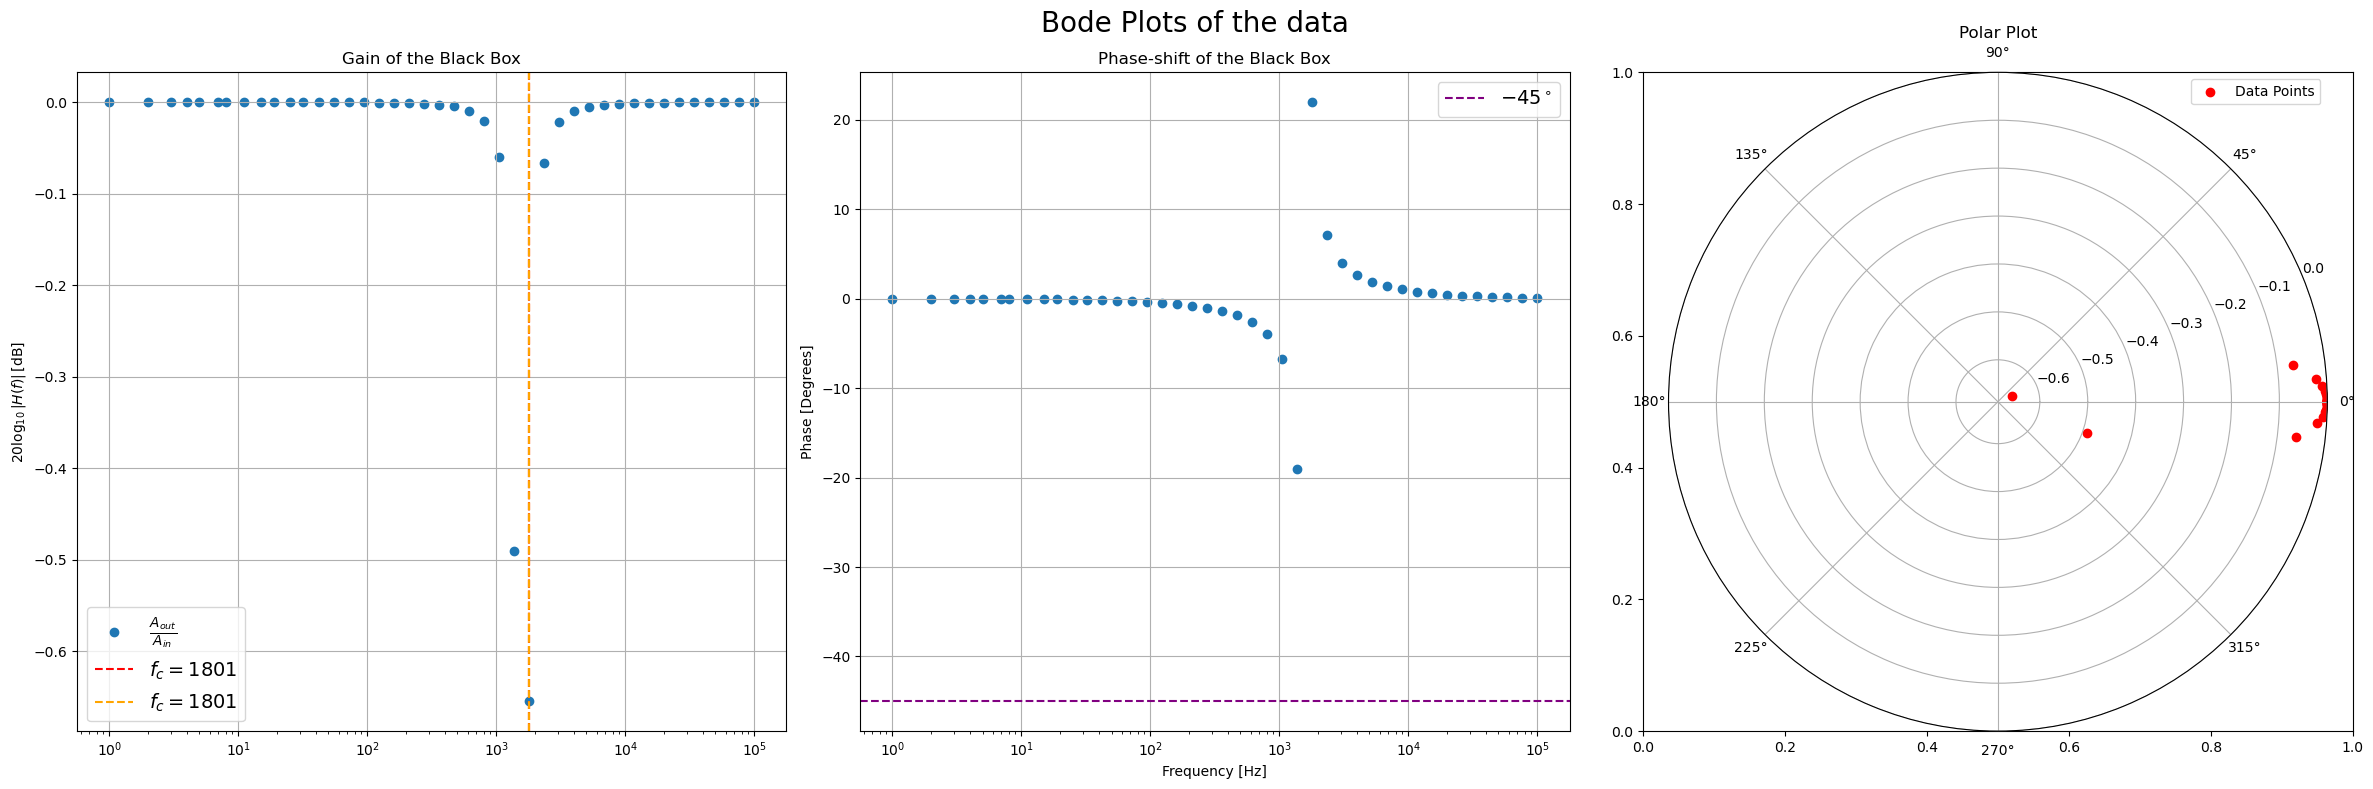

In [57]:
H_magnitudes, H_phaseshifts = daq.getMagnitudePhase(data_theoretical, frequencies, res_freq=True, cutoff_freq=True)

Bode plots of all types:

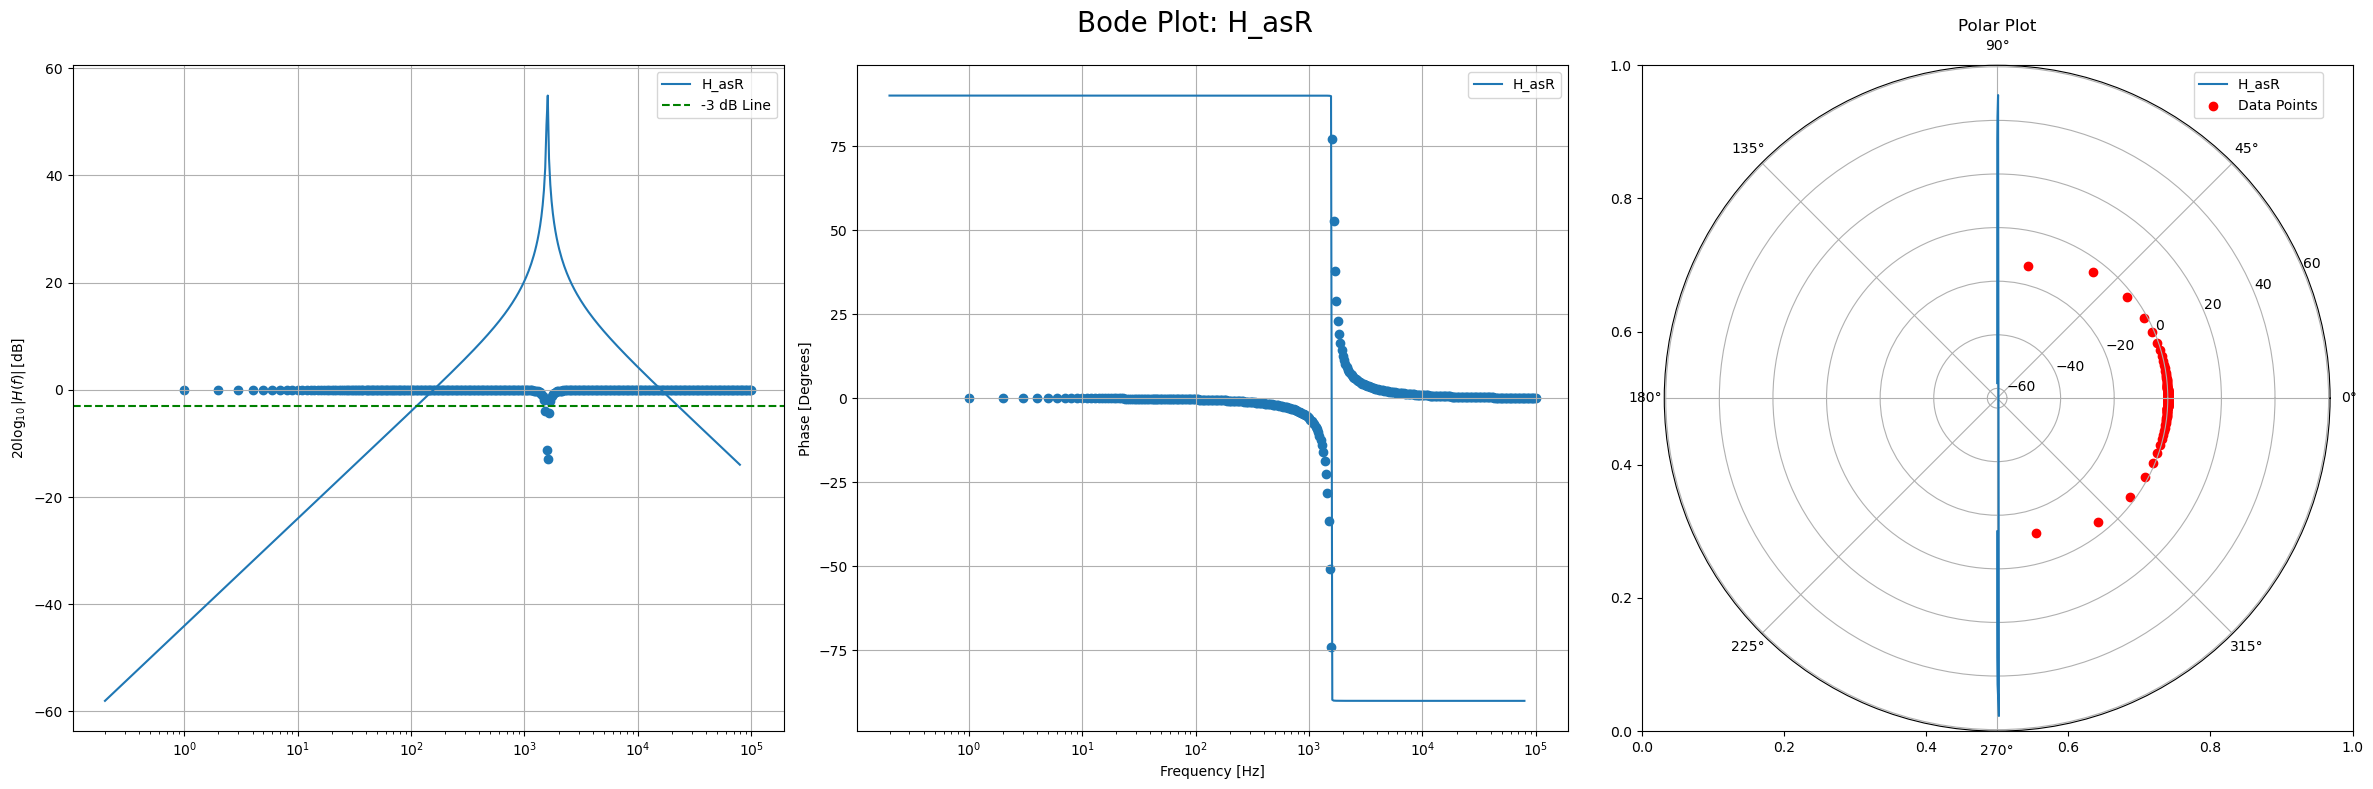

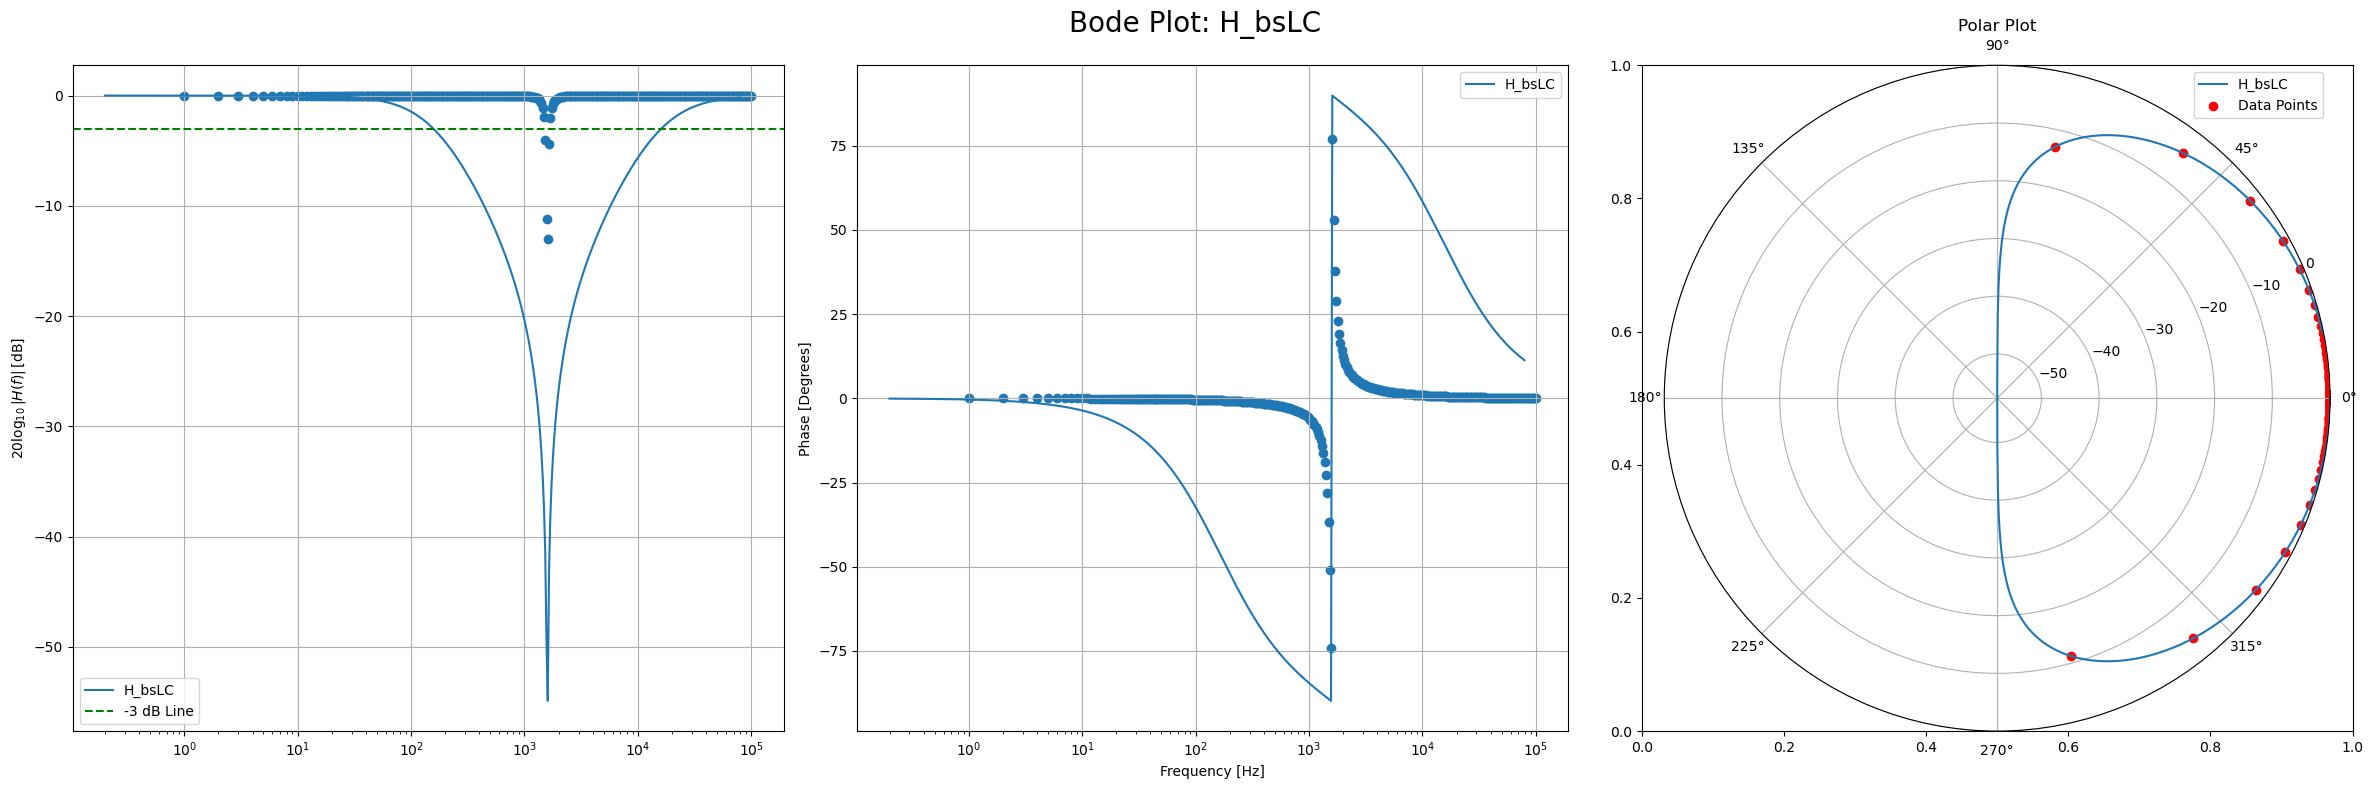

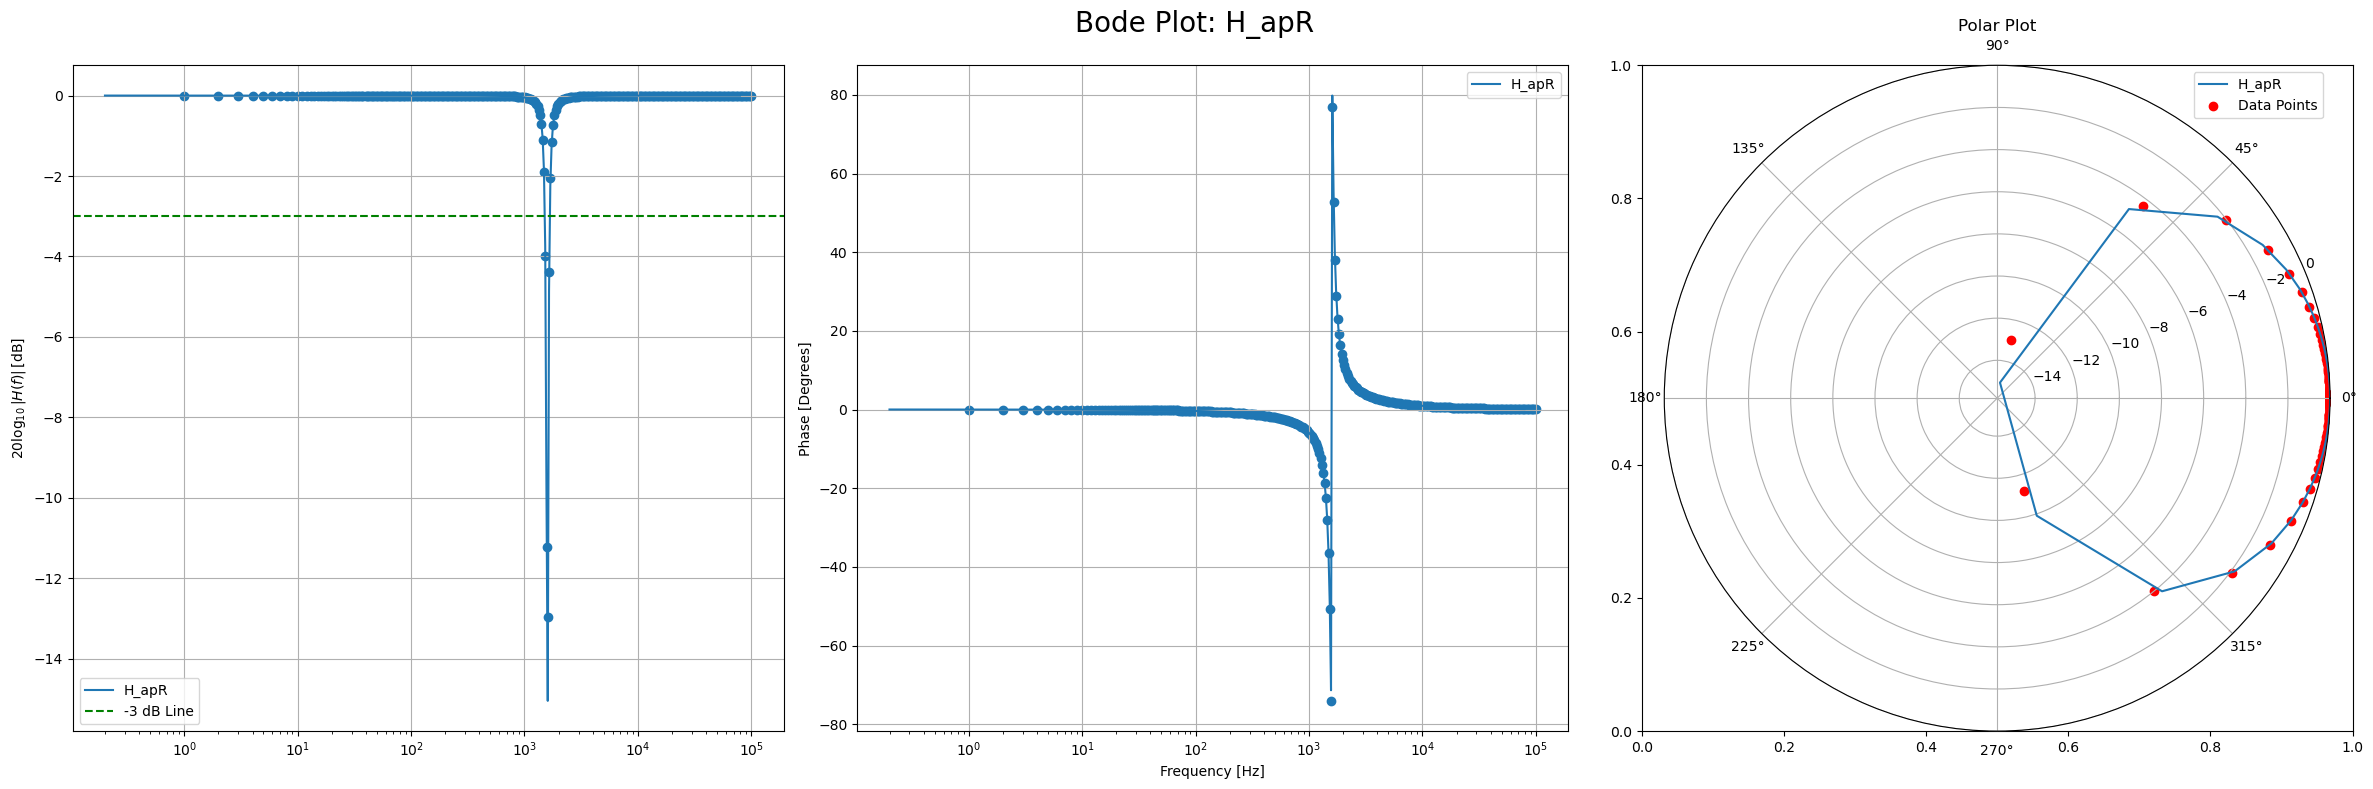

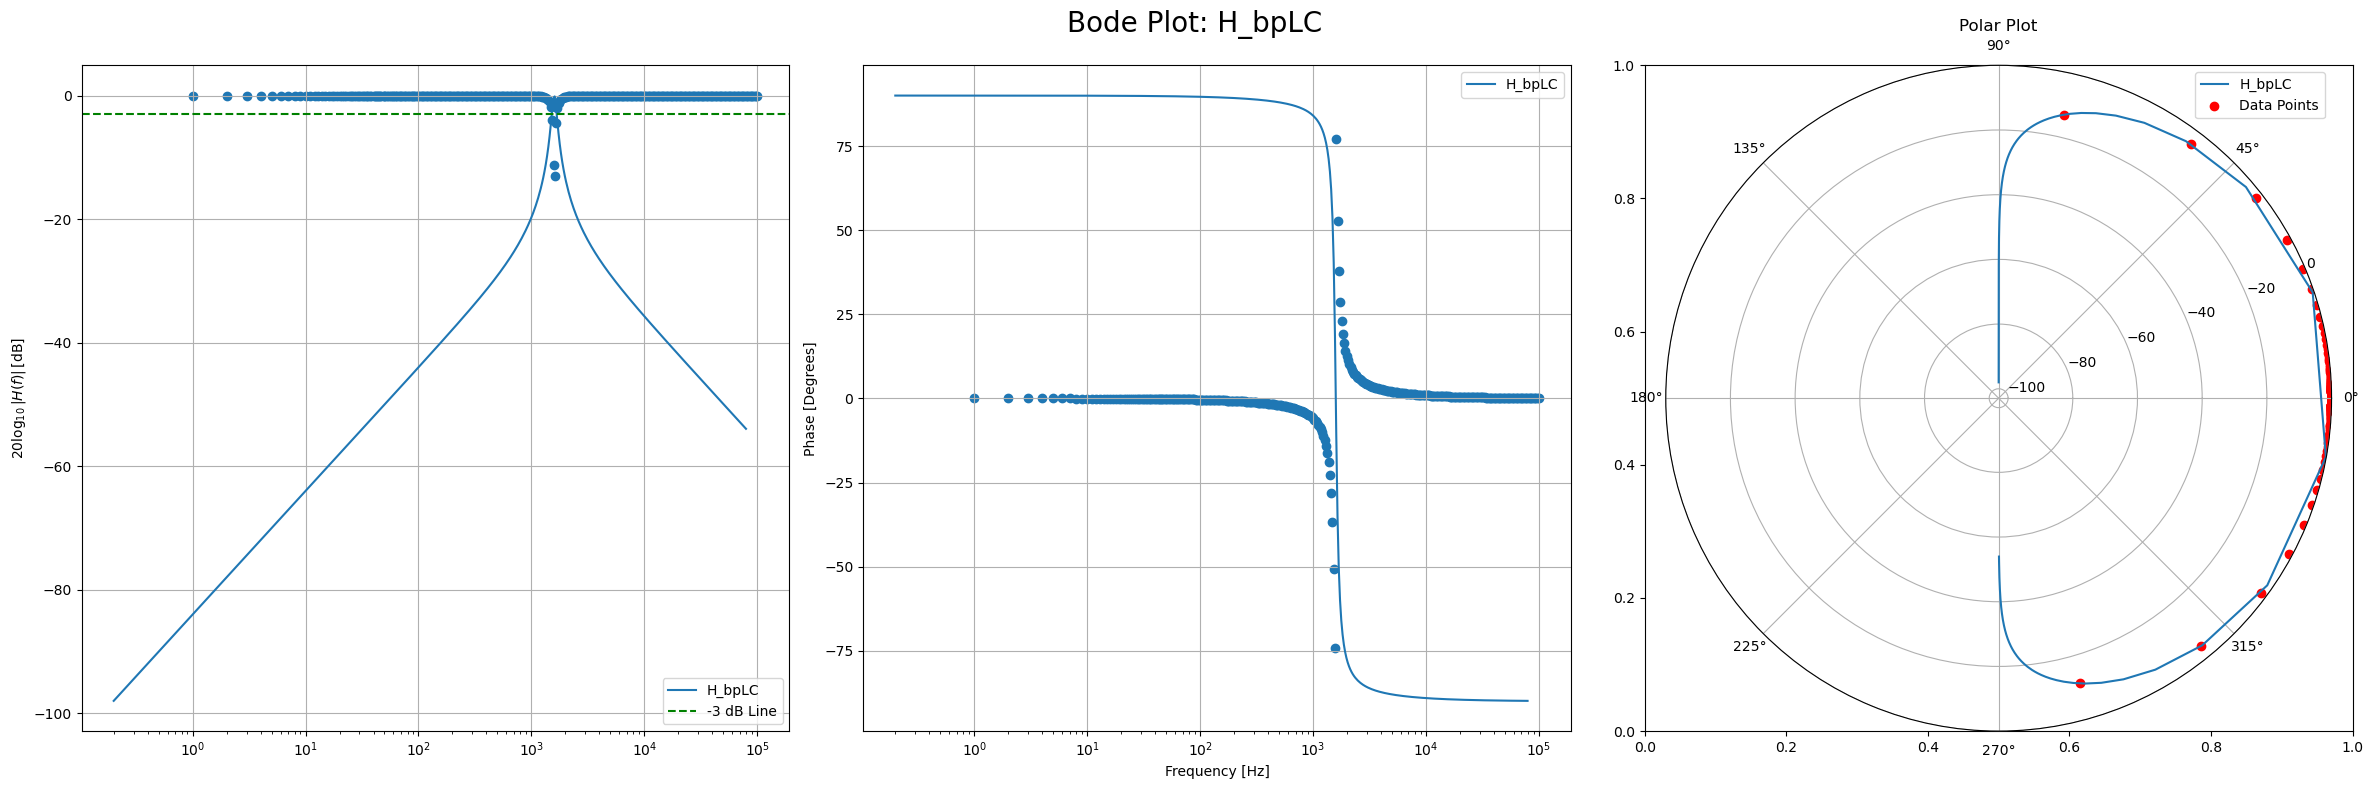

In [85]:
low_pass_list = [H_low, H_lowlow, H_asC, H_bsRC, H_apC, H_bpRL, H_RL_R, H_CL_C]
low_pass_labels = [r'H_low', r'H_lowlow', r'H_prLc', r'H_pRLc', r'H_asC', r'H_bsRC', r'H_apC', r'H_bpRL', r'H_RL_R', r'H_CL_C']

high_pass_list = [H_high, H_highhigh, H_asL, H_bsRL, H_apL, H_bpRC, H_RL_L, H_CL_L]
high_pass_labels = ['H_high', 'H_highhigh', 'H_asL', 'H_bsRL', 'H_apL', 'H_bpRC', 'H_RL_L', 'H_CL_L']

rest_list = [H_asR, H_bsLC, H_apR, H_bpLC]
rest_labels = ['H_asR', 'H_bsLC', 'H_apR', 'H_bpLC']

freqs = np.logspace(min_log_freq, 4.9, 500)
R = 1000
C = 1e-6
L = 1e-2

H_list = rest_list
H_labels = rest_labels

for i in range(0, len(H_list)):
    H_values = H_list[i](freqs, R, L, C)
    phi_values = np.angle(H_values)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 2, 2]})
    
    # Plot magnitude response
    ax1.plot(freqs, 20 * np.log10(np.abs(H_values)), label=H_labels[i])
    ax1.scatter(frequencies, 20 * np.log10(H_magnitudes))
    ax1.set_xscale('log')
    #ax1.set_title('Magnitude Transfer Function')
    ax1.axhline(-3, color='green', linestyle='--', label='-3 dB Line')
    ax1.set_ylabel(r'$20 \log_{10}|H(f)| \, \mathrm{[dB]}$')
    ax1.legend()
    ax1.grid()
    
    # Plot phase response
    ax2.plot(freqs, np.rad2deg(phi_values), label=H_labels[i])
    ax2.scatter(frequencies, H_phaseshifts)
    ax2.set_xscale('log')
    #ax2.set_title('Phase Transfer Function')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Phase [Degrees]')
    ax2.legend()
    ax2.grid()

    ax3 = plt.subplot(133, polar=True)  # Create a polar subplot
    ax3.plot(phi_values, 20 * np.log10(np.abs(H_values)), label=H_labels[i])
    ax3.scatter(np.deg2rad(H_phaseshifts), 20 * np.log10(H_magnitudes), label='Data Points', color='red')
    ax3.set_title('Polar Plot')
    ax3.legend()
    
    # Show and save the plot
    plt.suptitle(f'Bode Plot: {H_labels[i]}', fontsize=20)
    plt.tight_layout()
    plt.show()

Generate theoretical data: